In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os.path
import pandas as pd
import numpy as np
import math
import scipy.ndimage as ndimage
import random
import matplotlib
import matplotlib.pyplot as plt
from skimage import measure
%matplotlib inline

if os.getcwd() != '/content/drive/My Drive/DL_Final_Project':
  %cd 'drive/My Drive/DL_Final_Project'

from data_helper import LabeledDataset
from torch.utils.data import Dataset

matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

/content/drive/My Drive/DL_Final_Project


In [0]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [0]:
#unet
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
                
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)
    
class UNet(nn.Module):
    def __init__(self,num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1) #2 because binary 0/1
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.interpolate(enc4, center.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec3 = self.dec3(torch.cat([dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec2 = self.dec2(torch.cat([dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec1 = self.dec1(torch.cat([dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear',align_corners=True)], 1))
        final = self.final(dec1)
        output = F.interpolate(final, 800, mode='bilinear',align_corners=True) #upsample to be 800x800
        return output

In [0]:
#load UNet for bounding box predictions
unet_bb_model = UNet(num_classes=2)
unet_bb_model.load_state_dict(torch.load('2_Leafy_Green_Team/UNet-UNet_bb')['UNet_bb']) #bounding box
unet_bb_model.to(device)


KeyboardInterrupt: ignored

In [0]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

transform = torchvision.transforms.ToTensor()

# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [0]:
def bbox_to_label(target_object):
    categories = target_object[0]['category']
    bboxes = target_object[0]['bounding_box']

    output = 9*np.ones((800,800))
    #print(len(categories))

    for i in range(len(bboxes)):
        class_label = categories[i]
        this_bbox = bboxes[i]
        flx, frx, blx, brx = this_bbox[0]
        fly, fry, bly, bry = this_bbox[1]
        fx = math.floor(10*((flx + frx)/2) + 400)
        bx = math.floor(10*((blx + brx)/2) + 400)
        fy = math.floor(10*((fly + bly)/2) + 400)
        by = math.floor(10*((fry + bry)/2) + 400)

        #output[fx:bx, fy:by] = class_label
        #output[bx:fx, by:fy] = class_label

        output[fy:by, fx:bx] = class_label
        output[by:fy, bx:fx] = class_label

    return output

In [0]:
def bbox_to_label_bionary(target_object):
    categories = target_object[0]['category']
    bboxes = target_object[0]['bounding_box']

    output = np.zeros((800,800))
    #print(len(categories))

    for i in range(len(bboxes)):
        #class_label = categories[i]
        this_bbox = bboxes[i]
        flx, frx, blx, brx = this_bbox[0]
        fly, fry, bly, bry = this_bbox[1]
        fx = math.floor(10*((flx + frx)/2) + 400)
        bx = math.floor(10*((blx + brx)/2) + 400)
        fy = math.floor(10*((fly + bly)/2) + 400)
        by = math.floor(10*((fry + bry)/2) + 400)

        #output[fx:bx, fy:by] = class_label
        #output[bx:fx, by:fy] = class_label

        output[fy:by, fx:bx] = 1
        output[by:fy, bx:fx] = 1

    return output

In [0]:
def frankenstein(image_object):
    this_image = image_object[0]
    front = torch.cat((this_image[0], this_image[1], this_image[2]), 2)
    back = torch.cat((this_image[5], this_image[4], this_image[3]), 2)
    all_images = torch.cat((front, back), 1)
    all_images = all_images.unsqueeze(0)

    return all_images

unet_bb_model.eval()
for i,(sample, target, road_image, extra) in enumerate(trainloader):
    if i <1:
        image_test = frankenstein(sample)
        targ = bbox_to_label(target)

        #plt.figure(figsize=((2,2)))
        #plt.imshow(targ)
        #plt.show()

        model_input = torch.mean(sample[0],axis=0).unsqueeze(0)
        model_input = model_input.to(device)
        preds = unet_bb_model(model_input)[0]
        preds = F.softmax(preds)

        prediction = 1*(preds[1] > .1)
        prediction = prediction.cpu().numpy()
        
        #plt.figure(figsize=((2,2)))
        #plt.imshow(prediction)
        #plt.show()
    else:
        break


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


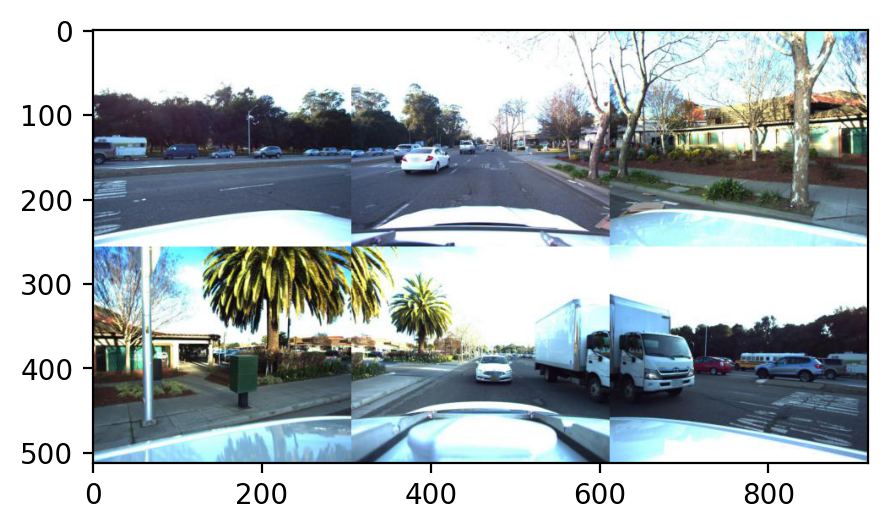

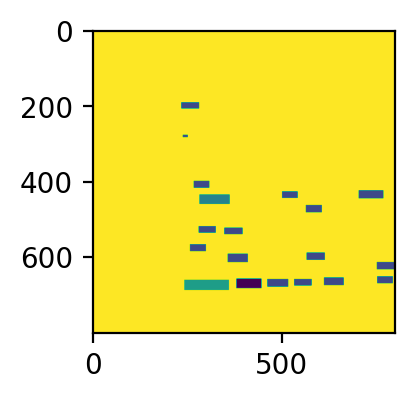

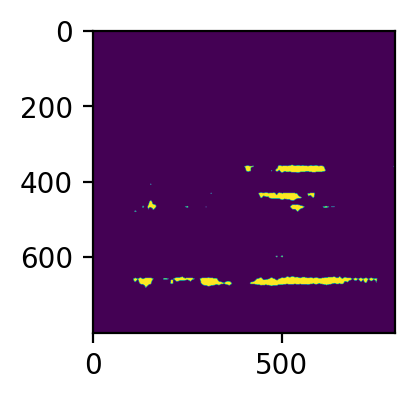

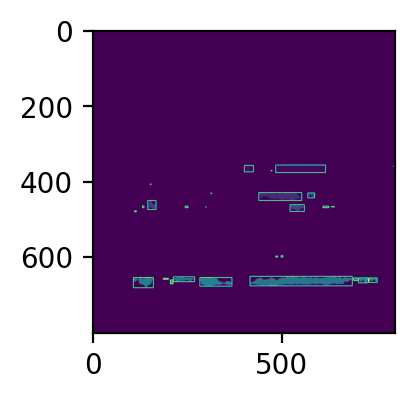

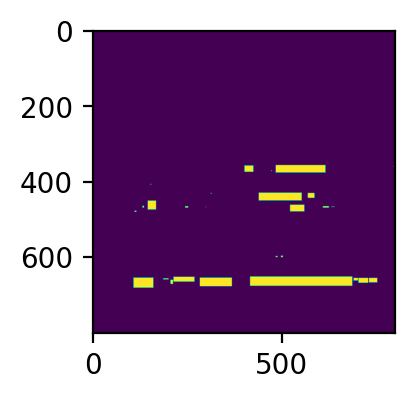

In [0]:
plt.imshow(image_test[0].numpy().transpose(1, 2, 0))

plt.figure(figsize=((2,2)))
plt.imshow(targ)
plt.show()

plt.figure(figsize=((2,2)))
plt.imshow(prediction)
plt.show()

def get_bboxes_from_output(model_output):
    test_label = measure.label(model_output)
    output = test_label.copy()
    #plt.figure(figsize=((2,2)))
    #plt.imshow(test_label)
    #plt.show()
    bboxes = []

    props = measure.regionprops(test_label)

    for prop in props:
        fy,fx,by,bx = prop.bbox
        fy, fx, by, bx = [min(fy,799), min(fx,799), min(by, 799), min(bx, 799)]
        flx, frx, blx, brx, fly, bly, fry, bry = (fx, fx, bx, bx, fy, fy, by, by)

        output[fy:by, fx-1:fx+1] = 50
        output[fy:by, bx-1:bx+1] = 50
        output[fy-1:fy+1, fx:bx] = 50
        output[by-1:by+1, fx:bx] = 50

        this_bbox = np.array([[flx, frx, blx, brx], [fly, fry, bly, bry]])
        this_bbox = (this_bbox - 400)/10
        bboxes.append(this_bbox)

    plt.figure(figsize=((2,2)))
    plt.imshow(output)
    plt.show()
    return torch.tensor(bboxes)

def simpler_get_label(bboxes):
    output = np.zeros((800,800))
    for i in range(len(bboxes)):
        class_label = 1
        this_bbox = bboxes[i]
        flx, frx, blx, brx = this_bbox[0]
        fly, fry, bly, bry = this_bbox[1]
        fx = math.floor(10*((flx + frx)/2) + 400)
        bx = math.floor(10*((blx + brx)/2) + 400)
        fy = math.floor(10*((fly + bly)/2) + 400)
        by = math.floor(10*((fry + bry)/2) + 400)

        #output[fx:bx, fy:by] = class_label
        #output[bx:fx, by:fy] = class_label

        output[fy:by, fx:bx] = class_label
        output[by:fy, bx:fx] = class_label

    return output

test_bboxes = get_bboxes_from_output(prediction).numpy()
test3 = simpler_get_label(test_bboxes)

plt.figure(figsize=((2,2)))
plt.imshow(test3)
plt.show()


(3, 512, 918)
(512, 918)


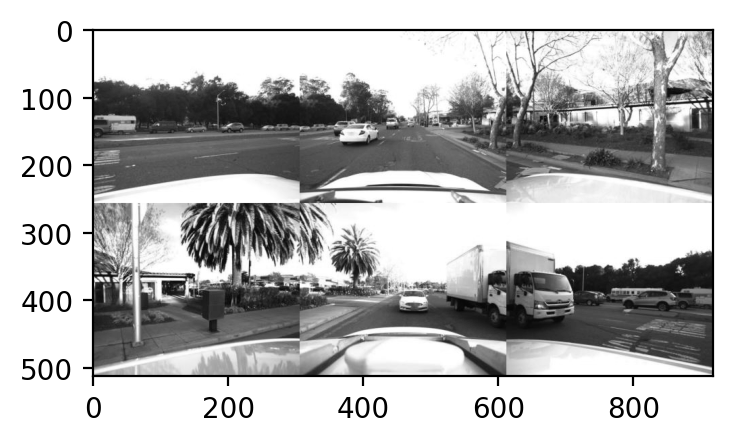

In [0]:
def rgb2gray(rgb):
    r, g, b = rgb[0,:,:], rgb[1,:,:], rgb[2,:,:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

test_image2 = image_test[0].numpy()
print(test_image2.shape)
test_image2 = rgb2gray(test_image2)
print(test_image2.shape)
plt.rcParams['image.cmap'] = 'gray'  
plt.figure(figsize=((4,4)))
plt.imshow(test_image2)
plt.show()

In [0]:
class Unsupervised_Model_wo_convtrans(nn.Module):
    def __init__(self):
        super(Unsupervised_Model_wo_convtrans, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=10, stride=1)
        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=5, stride=1)
        self.conv2_bn = nn.BatchNorm2d(10)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=5, stride=1)
        self.conv3_bn = nn.BatchNorm2d(3)
        self.linear1 = nn.Linear(in_features=110, out_features=512)
        self.linear2 = nn.Linear(in_features=177, out_features=918)
        #self.conv4 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=5, stride=1)
        #self.convtrans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=0, stride=2, dilation=1)

    def forward(self, x):
        #print('input data',x.size())
        x = self.conv1(x)
        #print('after first convolve:', x.size())
        x = F.relu(self.conv1_bn(x))
        #print('after first batch norm:', x.size())
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        #print('after first max pool:', x.size())

        x = self.conv2(x)
        #print('after second convolve:', x.size())
        x = F.relu(self.conv2_bn(x))
        #print('after second batch norm:', x.size())
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        #print('after second max pool:', x.size())

        x = self.conv3(x)
        #print('after third convolve:', x.size())
        x = F.relu(self.conv3_bn(x))
        #print('after third batch norm:', x.size())
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        #print('after third max pool:', x.size())
        x = x.view(-1, 177, 110)
        #print('after first reshape:', x.size())  
        x = F.relu(self.linear1(x))
        #print('after first linear layer:', x.size())
        x = x.view(-1, 512, 177)
        #print('after second reshape:', x.size())  
        x = self.linear2(x)
        #print('after second linear layer:', x.size())
      
        return x

In [0]:
def train(model, optimizer, epoch, log_interval = 100):
    # Set model to training mode
    #model.to(device)
    model.train()
    # Set model to training mode
    criterion_mse = torch.nn.MSELoss(reduction='mean')
    # Loop through data points
    for batch_idx,(image) in enumerate(unlabeled_trainloader):

        model_image = frankenstein(image).double()
        label = rgb2gray(model_image[0]).double()
        model_image = model_image.to(device)
        label = label.to(device)
        
        # Zero out the ortimizer
        optimizer.zero_grad()
        
        # Pass data through model
        preds = model(model_image)
        
        # Compute the loss
        #print(preds.size())
        #print(label.size())
        loss = criterion_mse(preds[0], label)
        #print(loss)
        # Backpropagate loss
        loss = loss.type(torch.DoubleTensor)
        #loss = loss.double()
        loss.double().backward()
        
        # Make a step with the optimizer
        optimizer.step()

        
        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx, len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

In [0]:
if False:
    model_wo_convtrans = Unsupervised_Model_wo_convtrans()
    model_wo_convtrans = model_wo_convtrans.double()
    model_wo_convtrans.to(device)
    optimizer = torch.optim.SGD(model_wo_convtrans.parameters(),lr=.01, momentum=0.9)

    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    for epoch in range(1, 4):

        # Train model
        train(model_wo_convtrans, optimizer, epoch, log_interval = 500)
        torch.save(model_wo_convtrans.state_dict(), 'encoder_model_wo_convtrans')

In [0]:


upsample_model = Unsupervised_Model_wo_convtrans()
upsample_model = upsample_model.double()
upsample_model.to(device)

upsample_model.load_state_dict(torch.load('prince_encoder_model_wo_convtrans'))

<All keys matched successfully>

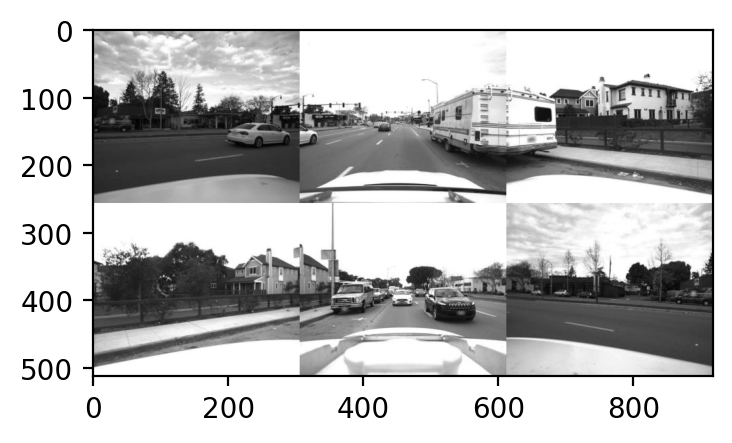

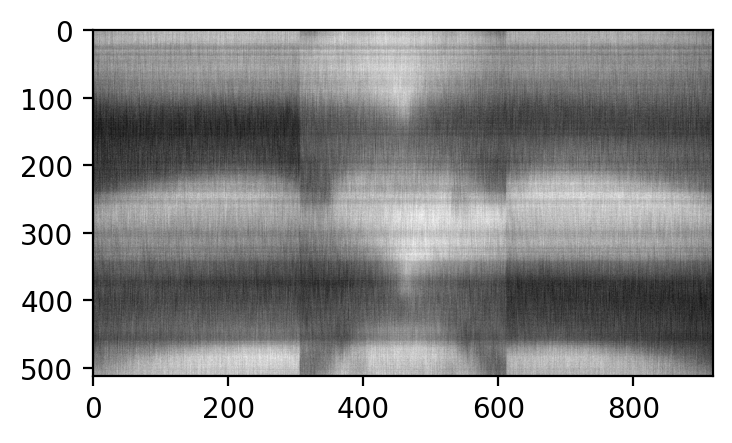

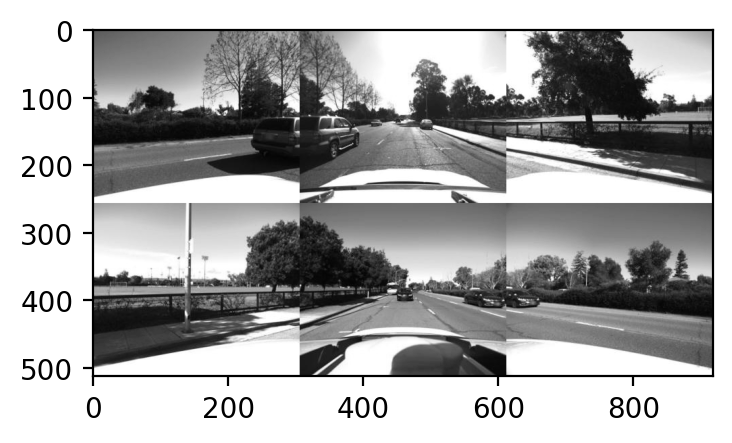

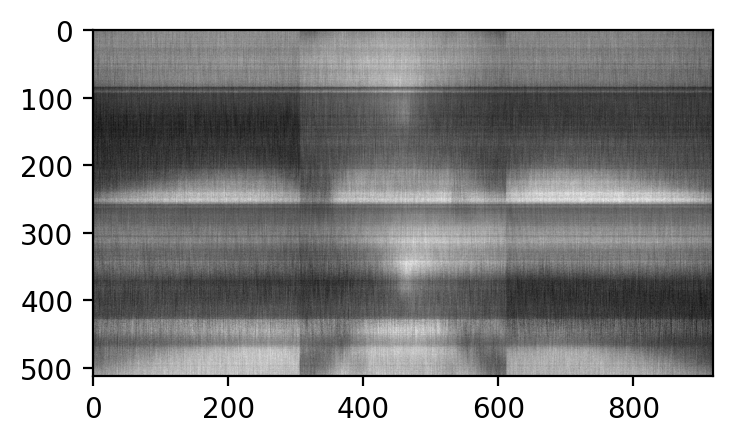

In [0]:
upsample_model.eval()
#optimizer = torch.optim.SGD(unet_semisupervised.parameters(),lr=.01, momentum=0.9)
for batch_idx,(image) in enumerate(trainloader):
    if batch_idx <= 1:
        model_image = frankenstein(image[0]).double()
        label = rgb2gray(model_image[0]).double()

        plt.rcParams['image.cmap'] = 'gray'  
        plt.figure(figsize=((4,4)))
        plt.imshow(label)
        plt.show()

        model_image = model_image.to(device)
        label = label.to(device)
        
        # Zero out the ortimizer
        #optimizer.zero_grad()
        
        # Pass data through model
        preds = upsample_model(model_image)
        pred = preds[0].cpu().detach().numpy()
        plt.rcParams['image.cmap'] = 'gray'  
        plt.figure(figsize=((4,4)))
        plt.imshow(pred)
        plt.show()

    else:
        break

In [0]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

#upsample_model.linear1 = Identity()
upsample_model.linear2 = Identity()

freeze_model(upsample_model)

In [0]:
#unet with unsupervised output
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
                
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            #nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.Conv2d(in_channels, middle_channels, kernel_size=2),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            #nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=2),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)
    
class UNet2(nn.Module):
    def __init__(self,num_classes):
        super(UNet2, self).__init__()
        #self.enc1 = _EncoderBlock(3, 64)
        self.enc1 = _EncoderBlock(1, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1) #2 because binary 0/1
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.interpolate(enc4, center.size()[2:], mode='bilinear',align_corners=True)], 1))
        #print(dec4.size())
        dec3 = self.dec3(torch.cat([dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec2 = self.dec2(torch.cat([dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear',align_corners=True)], 1))
        dec1 = self.dec1(torch.cat([dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear',align_corners=True)], 1))
        final = self.final(dec1)
        output = F.interpolate(final, 800, mode='bilinear',align_corners=True) #upsample to be 800x800
        return output

In [0]:
unet_semisupervised = UNet2(num_classes=2)
unet_semisupervised = unet_semisupervised.double()
optimizer = torch.optim.SGD(unet_semisupervised.parameters(),lr=.01, momentum=0.9)
criterion_entropy = nn.CrossEntropyLoss()

criterion_nll = torch.nn.NLLLoss().double()

def train_semisuper(model, pretrained_model, optimizer, epoch, log_interval = 100):
    # Set model to training mode
    #model.to(device)
    model.train()
    model.to(device)
    pretrained_model.eval()
    pretrained_model.to(device)
    # Set model to training mode
    criterion_mse = torch.nn.MSELoss(reduction='mean')
    # Loop through data points
    for batch_idx,(sample, target, road_image, extra) in enumerate(trainloader):

        label = torch.tensor(bbox_to_label_bionary(target))
        label = label.unsqueeze(0)
        label = label.to(device)

        model_image = frankenstein(sample[0].unsqueeze(0)).double()
        model_image = model_image.to(device)
        unsupervised_output = pretrained_model(model_image).unsqueeze(0)

        #supervised_input = unsupervised_output.repeat(1,3,1,1)

        # Zero out the ortimizer
        optimizer.zero_grad()
        
        # Pass data through model
        preds = model(unsupervised_output)
        
        # Compute the loss
        loss = criterion_entropy(preds, label.long())
        #print(loss)
        # Backpropagate loss
        #loss = loss.double()
        loss.backward()
        
        # Make a step with the optimizer
        optimizer.step()

        
        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx, len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
            
optimizer = torch.optim.SGD(unet_semisupervised.parameters(),lr=.01, momentum=0.9)           
train_semisuper(unet_semisupervised, upsample_model, optimizer, 1, log_interval = 100)
#torch.save(model_wo_convtrans.state_dict(), 'semi_supervised_frozen')

Train Epoch: 1 [0/3528 (0%)]	Loss: 0.758973
Train Epoch: 1 [100/3528 (3%)]	Loss: 0.119408
Train Epoch: 1 [200/3528 (6%)]	Loss: 0.024492
Train Epoch: 1 [300/3528 (9%)]	Loss: 0.045931
Train Epoch: 1 [400/3528 (11%)]	Loss: 0.044284
Train Epoch: 1 [500/3528 (14%)]	Loss: 0.149729
Train Epoch: 1 [600/3528 (17%)]	Loss: 0.083258
Train Epoch: 1 [700/3528 (20%)]	Loss: 0.107965
Train Epoch: 1 [800/3528 (23%)]	Loss: 0.077775
Train Epoch: 1 [900/3528 (26%)]	Loss: 0.173657
Train Epoch: 1 [1000/3528 (28%)]	Loss: 0.086534


KeyboardInterrupt: ignored

In [0]:
unet_semisupervised = UNet2(num_classes=2)
unet_semisupervised = unet_semisupervised.double()
unet_semisupervised.to(device)

unet_semisupervised.load_state_dict(torch.load('semi_supervised_frozen'))

FileNotFoundError: ignored

In [0]:
for i,(sample, target, road_image, extra) in enumerate(trainloader):
    if i <1:
        image_test = frankenstein(sample)
        targ = bbox_to_label(target)

        #plt.figure(figsize=((2,2)))
        #plt.imshow(targ)
        #plt.show()

        model_input = torch.mean(sample[0],axis=0).unsqueeze(0)
        model_input = model_input.to(device)
        preds = unet_bb_model(model_input)[0]
        preds = F.softmax(preds)

        prediction = 1*(preds[1] > .1)
        prediction = prediction.cpu().numpy()